# Term Project


### *Matt Danielson, Samuel Kaessner*


## Intro

For our project we worked on a dataset from the UCI machine learning repository to classify photos of faces. The photos were of different people with a number of variations in their poses including whether they wore sunglasses or not, the direction they were looking, and the emotion they were displaying. We decided to use a neural network to classify the images, with each pixel representing a weight into the hidden layer of the neural net. We shuffled the images and used 80% of them as training data, and withheld 20% to be used for test data.

The data was collected by Tom Mitchell of Carnegie Mellon University and is available at the following address:

http://archive.ics.uci.edu/ml/datasets/cmu+face+images

The images were in PGM format, so the first thing we did was write a function to read the pixel data into an array where each array element was the grayscale value of that pixel.

In [31]:
import sys
import os
import re
import numpy as np
import neuralnetworksA4 as nn
import mlutilities as ml
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
''' Baseline code by cgohlke on StackOverflow, from this answer:
    https://stackoverflow.com/a/7369986
    Modified somewhat. 
'''
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """

    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5[\s\r\n]*"
            b"(\d+)[\s\r\n]*"
            b"(\d+)[\s\r\n]*"
            b"(\d+)[\s\r\n])", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            )

Next we decided to write some code that will walk through the directory of image files and read each file into an array which we will use with numpy called X.
We also needed to establish some target values so for each value we created an array of target values called info. The target value names are described in the names of the files seperated by underscores. Using this, we were able to select which target variable to use when loading in our data where given by an index where 1 is the direction the subjects are looking, 2 is the expression or emotion on their face, and 3 is if they are wearing sunglasses or open.


In [33]:
''' 
Loads in PGM Data, by digging through the given directory. Num specifies which
attribute of the image to use as the target. This is given by:
1 - Direction
2 - Expression
3 - Sunglasses
Anything else - All 3 attributes
'''
def loadPGMData(rootDir, num, level):
    values = []
    targets = []
    for dirName, subdirList, fileList in os.walk(rootDir):
        for fname in fileList:
            ending = str(level) + ".pgm"
                
            if(fname.endswith(ending)):
                values.append(read_pgm(os.path.join(dirName, fname)))
                
                if num is 1: # Direction
                    splits = fname.split("_")
                    fname = splits[1]
                elif num is 2: # Expression
                    splits = fname.split("_")
                    fname = splits[2]
                elif num is 3: # Sunglasses
                    splits = fname.split("_")
                    fname = splits[3]
                else:
                    fname = fname[fname.find("_") + 1:-4]
                targets.append(fname)
            
            
    X = np.asarray(values)
    T = np.asarray(targets).reshape((-1, 1))
    return ml.partition(X, T, 0.8, shuffle=True, classification=True)
        

An example of one of the images that we analyzed is here:

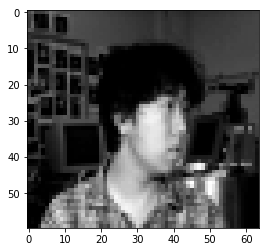

In [34]:
plt.imshow(read_pgm("faces/an2i/an2i_left_neutral_open_2.pgm").reshape((60, 64)),interpolation='nearest',cmap='gray')


Our predictions for the data was follows:

We predict that whether or not the subject is wearing sunglasses will be the easiest category to predict. This is because the sunglasses provide a great amount of contrast in the middle of the image, between the brighter colors of the face and the dark of the sunglasses, so we expect the pixels in the middle of the image will be weighted the most heavily as inputs to the neural net. Other pixels may not have much weight at all, as for each picture there is a dark background around the top and side edges of the image.

We expect that classifying the direction the subject is looking will be more difficult, as it will rely on a smaller set of pixels around the edge of the face to see, for example, which way their nose is pointing.

We think that the facial expression will be most difficult of all because it will rely on a very small set of pixels around the corners of the mouth.

The images also come in two resolutions. We expect that especially for the direction of the head and emotion, the higher resolution will be easier to classify. However, we predict that the sunglasses will actually go down with higher resolution because there will be more hidden values trying to determine the middle of the face instead of only a few heavy, dark pixels where the sunglasses are.




The first thing we tested was the direction the head was pointing, which can be left, right, up, or straight. We trained with a neural net of 1000 iterations, and hidden layers of [50,50,50]. We can also graph the error of the function as the neural net progresses:

4.90769293581e-17


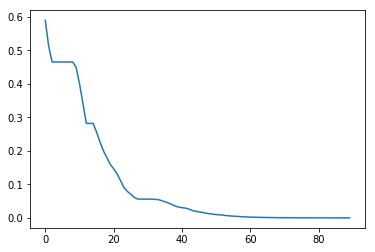

In [35]:
XTrain, TTrain, XTest, TTest = loadPGMData('faces', 1, 4)
neuralNet = nn.NeuralNetworkClassifier(XTrain.shape[1], [50, 50, 50], np.unique(np.squeeze(TTrain)).shape[0])
neuralNet.train(XTrain, TTrain, nIterations=1000, verbose=True)
plt.plot(neuralNet.getErrors())

We define a percent correct function to see how well our networks do. 

In [36]:
def percentCorrect(A, B):
    return np.sum(A == B) / len(B) * 100

In [37]:

PTrain = neuralNet.use(XTrain)
PTest = neuralNet.use(XTest)

print('\nTraining data: Percent Correct  {:.2f}'.format(percentCorrect(TTrain, PTrain)))
print('\nTesting data: Percent Correct  {:.2f}'.format(percentCorrect(TTest, PTest)))



Training data: Percent Correct  100.00

Testing data: Percent Correct  95.16


We can see that the neural net predicted face direction very well!

Let's repeat this for each of the other attributes. First with emotion which can be sad, happy, angry, or neutral:

SCG: Iteration 100 fValue Eval 0.0167572023125 Scale 1e-15
SCG: Iteration 200 fValue Eval 5.63416642807e-05 Scale 1e-15
SCG: Iteration 300 fValue Eval 2.45611317006e-09 Scale 1e-15
2.14892091714e-16

Training data: Percent Correct  100.00

Testing data: Percent Correct  13.60


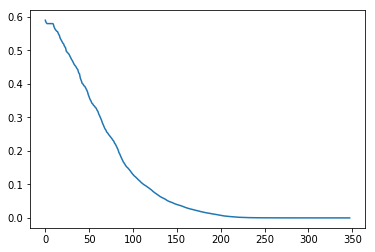

In [38]:
XTrain, TTrain, XTest, TTest = loadPGMData('faces', 2, 4)
neuralNet = nn.NeuralNetworkClassifier(XTrain.shape[1], [50, 50, 50], np.unique(np.squeeze(TTrain)).shape[0])
neuralNet.train(XTrain, TTrain, nIterations=1000, verbose=True)
plt.plot(neuralNet.getErrors())

PTrain = neuralNet.use(XTrain)
PTest = neuralNet.use(XTest)

print('\nTraining data: Percent Correct  {:.2f}'.format(percentCorrect(TTrain, PTrain)))
print('\nTesting data: Percent Correct  {:.2f}'.format(percentCorrect(TTest, PTest)))

This had a very low prediction. We can also try use it to predict sunglasses or open:

6.94685380487e-17

Training data: Percent Correct  100.00

Testing data: Percent Correct  94.40


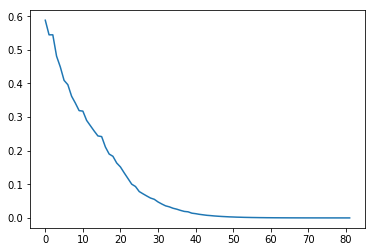

In [39]:
XTrain, TTrain, XTest, TTest = loadPGMData('faces', 3, 4)
neuralNet = nn.NeuralNetworkClassifier(XTrain.shape[1], [50, 50, 50], np.unique(np.squeeze(TTrain)).shape[0])
neuralNet.train(XTrain, TTrain, nIterations=1000, verbose=True)
plt.plot(neuralNet.getErrors())

PTrain = neuralNet.use(XTrain)
PTest = neuralNet.use(XTest)

print('\nTraining data: Percent Correct  {:.2f}'.format(percentCorrect(TTrain, PTrain)))
print('\nTesting data: Percent Correct  {:.2f}'.format(percentCorrect(TTest, PTest)))

Sunglasses had a high predictability as well. The next thing we wanted to try was a higher resolution image. We created a method testResolution that trains the neural net again for the specified target variable.

In [40]:
def testResolution(targetVariable, level):
    XTrain, TTrain, XTest, TTest = loadPGMData('faces', targetVariable, level)
    neuralNet = nn.NeuralNetworkClassifier(XTrain.shape[1], [50, 50, 50], np.unique(np.squeeze(TTrain)).shape[0])
    neuralNet.train(XTrain, TTrain, nIterations=1000, verbose=True)
    plt.plot(neuralNet.getErrors())

    PTrain = neuralNet.use(XTrain)
    PTest = neuralNet.use(XTest)

    print('\nTraining data: Percent Correct  {:.2f}'.format(percentCorrect(TTrain, PTrain)))
    print('\nTesting data: Percent Correct  {:.2f}'.format(percentCorrect(TTest, PTest)))

Higher resolution direction:

1.15420852754e-16

Training data: Percent Correct  100.00

Testing data: Percent Correct  95.16


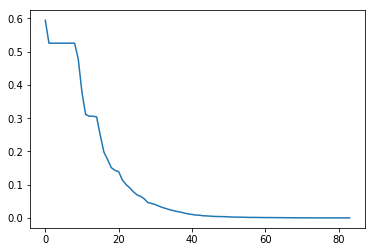

In [41]:
testResolution(1, 2)

Higher resolution expression:

SCG: Iteration 100 fValue Eval 0.00420203404141 Scale 1e-15
SCG: Iteration 200 fValue Eval 1.78714367355e-06 Scale 1e-15
8.65828154542e-17

Training data: Percent Correct  100.00

Testing data: Percent Correct  16.00


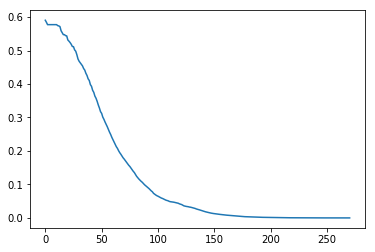

In [42]:
testResolution(2, 2)

Higher resolution sunglasses:

6.82916065309e-17

Training data: Percent Correct  100.00

Testing data: Percent Correct  91.20


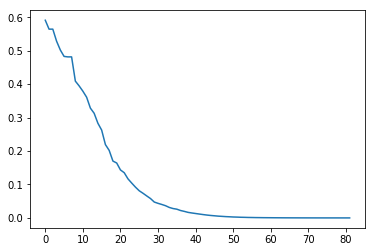

In [43]:
testResolution(3, 2)

## Conclusion
Using our neural network approach, we were able to classify image data of faces with a varying degree of accuracy based on what the attribute was. Big, obvious differences like wearing sunglasses were easier to classify than subtler features like emotion. In particular, it seemed that emotion was too fine a feature for our neural network to classify with a high degree of confidence. Some applications for this type of machine learning could be facial recognition software, security cameras, or programs that can describe the world to someone who is visually impaired.
